This notebook explores the concepts of windfall and regreet with a Gaussian Process model used as the underlying model

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
import scipy.stats as stats

For simplicity, we will start with a 2-variable space, assumed normalized 0..1, and the failure amount will be a simple function, with failure amounts less than zero indicating infeasibility.  We will make a simple function with a linear term that ranges from -1 to 1 at a simple angle, and then a sin term to control the failure amount:

In [2]:
def failure_amount(x1, x2, a1, a2, w1, w2):
    '''
    x1 - location in x1 space
    x2 - location in x2 space
    a1 - amplitude constant for the x1 sin term
    a2 - amplitude constant for the x2 sin term
    w1 - frequency of the x1 sin term - x1 is converted to run from 0 to 2pi automatically
    w2 - frequency of the x2 sin term
    '''
    return 0.5*(0.5-x1) + 0.5*(0.5-x2) + a1*math.sin(w1*2.*math.pi*x1) + a2*math.sin(w2*2.*math.pi*x2)

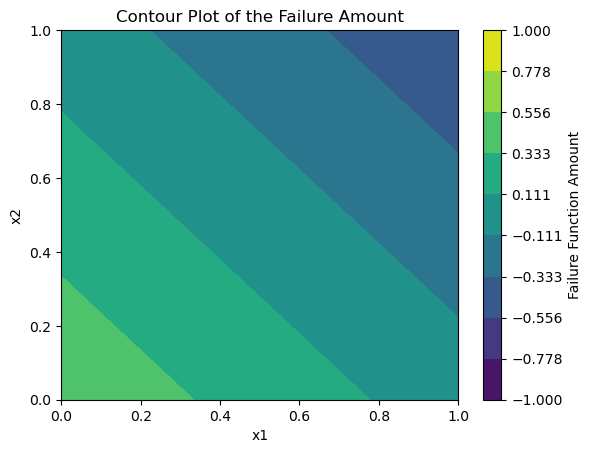

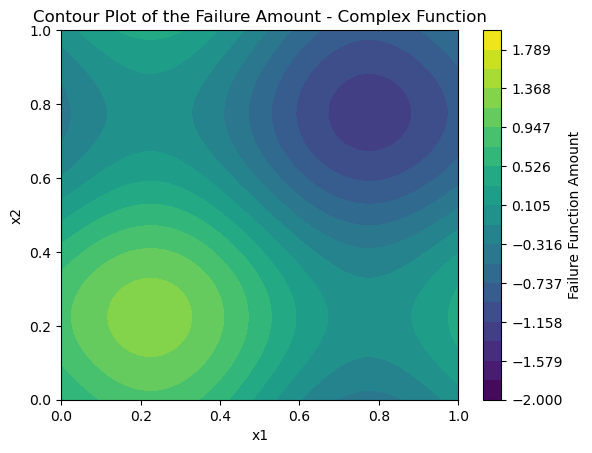

<Figure size 640x480 with 0 Axes>

In [3]:
nx1, nx2 = (100, 100)
x1 = np.linspace(0, 1, nx1)
x2 = np.linspace(0, 1, nx2)
x1v, x2v = np.meshgrid(x1, x2)
z1v = np.empty_like(x1v)
def getFunction(x1v, x2v, z1v, a1, a2, w1, w2):
    for i in range(x1v.shape[0]):
        for j in range(x2v.shape[1]):
            z1v[i, j] = failure_amount(x1v[i,j], x2v[i,j], a1, a2, w1, w2)

#Start with the simplest failure plot - no sin terms
getFunction(x1v, x2v, z1v, 0, 0, 1, 1)

levels = np.linspace(-1, 1, 10)  # Adjust the number of levels as needed
contour = plt.contourf(x1v, x2v, z1v, levels=levels, cmap='viridis')  # Choose a colormap
plt.colorbar(contour, label='Failure Function Amount')  # Add colorbar with label

plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Contour Plot of the Failure Amount')
plt.show()

#Adding some complexity to the failure plot
z2v = np.empty_like(x1v)
getFunction(x1v, x2v, z2v, 0.5, 0.5, 1, 1)
levels = np.linspace(-2, 2, 20)  # Adjust the number of levels as needed
contour = plt.contourf(x1v, x2v, z2v, levels=levels, cmap='viridis')  # Choose a colormap
plt.colorbar(contour, label='Failure Function Amount')  # Add colorbar with label

plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Contour Plot of the Failure Amount - Complex Function')
plt.show()
plt.clf()


The next step is to build a Gaussian Process model from a limite sample of the space

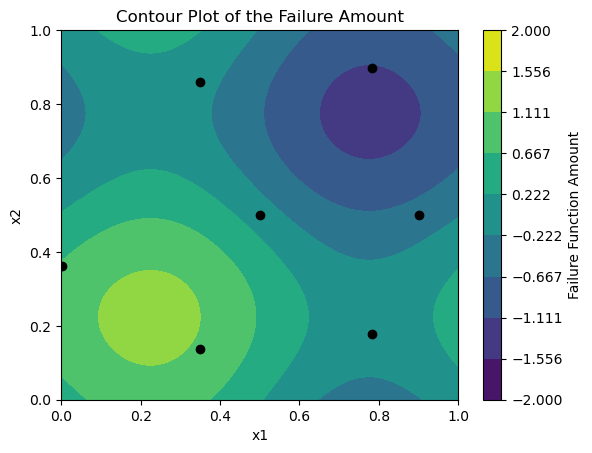

<Figure size 640x480 with 0 Axes>

In [4]:
x1s = np.array([0.001896591, 0.783572131, 0.349142946, 0.349953479, 0.78222671, 0.9, 0.5])
x2s = np.array([0.36089457, 0.178845999, 0.86096816,  0.136766199 ,0.896315636, 0.5, 0.5])
z1s = np.empty_like(x2s)

for i in range(x1s.shape[0]):
    z1s[i] = failure_amount(x1s[i], x2s[i], 0.5, 0.5, 1, 1)

levels = np.linspace(-2, 2, 10)  # Adjust the number of levels as needed
contour = plt.contourf(x1v, x2v, z2v, levels=levels, cmap='viridis')  # Choose a colormap
plt.colorbar(contour, label='Failure Function Amount')  # Add colorbar with label

plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Contour Plot of the Failure Amount')
plt.scatter(x1s, x2s, color='black')
plt.show()
plt.clf()

Now build a GP model from the sample points

C:\Users\joeyvan\AppData\Local\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


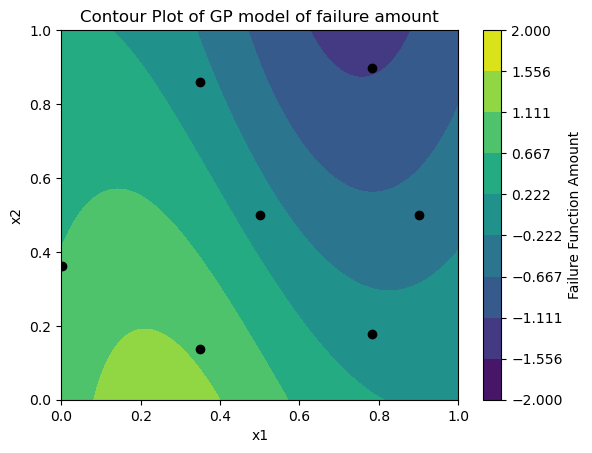

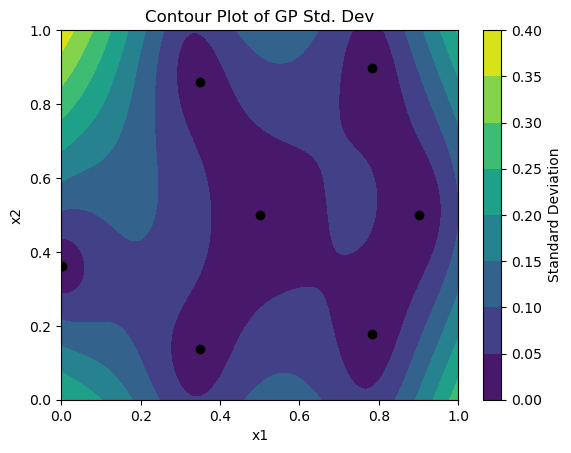

<Figure size 640x480 with 0 Axes>

In [5]:
kernel = 1.0 * RBF(length_scale=np.array([1,1]), length_scale_bounds=(1e-2, 1e3)) + WhiteKernel(
    noise_level=1, noise_level_bounds=(1e-5, 1e1))
gpr = GaussianProcessRegressor(kernel=kernel, alpha=0.00001)

x_train = np.column_stack((x1s, x2s))
y_train = z1s
gpr.fit(x_train, y_train)

z1gp = np.empty_like(z1v)
z1gpstd = np.empty_like(z1v)

for i in range(x1v.shape[0]):
    for j in range(x2v.shape[1]):
        model_input = np.array([[x1v[i,j], x2v[i,j]]])
        z1gp[i, j], z1gpstd[i,j] = gpr.predict(model_input, return_std=True)

        
contour = plt.contourf(x1v, x2v, z1gp, levels=levels, cmap='viridis')  # Choose a colormap
plt.colorbar(contour, label='Failure Function Amount')  # Add colorbar with label

plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Contour Plot of GP model of failure amount')
plt.scatter(x1s, x2s, color='black')
plt.show()
plt.clf()

contour = plt.contourf(x1v, x2v, z1gpstd, cmap='viridis')  # Choose a colormap
plt.colorbar(contour, label='Standard Deviation')  # Add colorbar with label

plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Contour Plot of GP Std. Dev')
plt.scatter(x1s, x2s, color='black')
plt.show()
plt.clf()


With the GP model, now regret and windfall can be calculated. The process will run as follows

1:Cycle through the model

2: If the mean value of the GP is > 0 at a point, the point is feasible.  This is  potential point of regret.  Calculate the weighted contribution to the regret total as the probability (based on the st dev.) that this point could come out < 0 later.  Set the windfall value to this point to N/a (here we will use a number big enough that it won't plot on the final contour)

3: If the the mean value of the GP is < 0, the point is currently infeasible, and is a windfall candidate. Caclulate the probability that the point would become feasible in the future, add the area-weighted contribution to the windfall total

This gets a simple scalar total for regret and windfall for a given design space

Stats for this run
Total windfall  [0.00870413]
Total regret  [0.0178733]


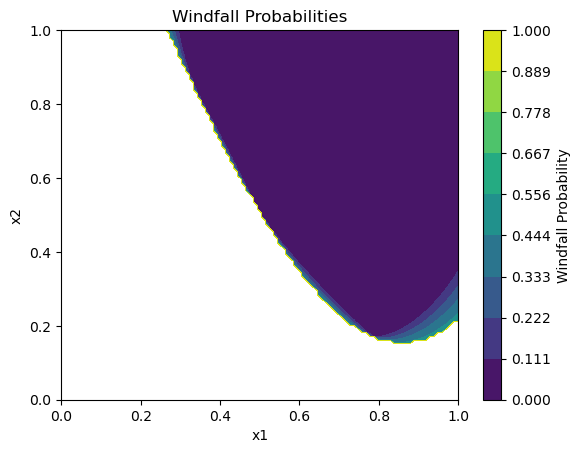

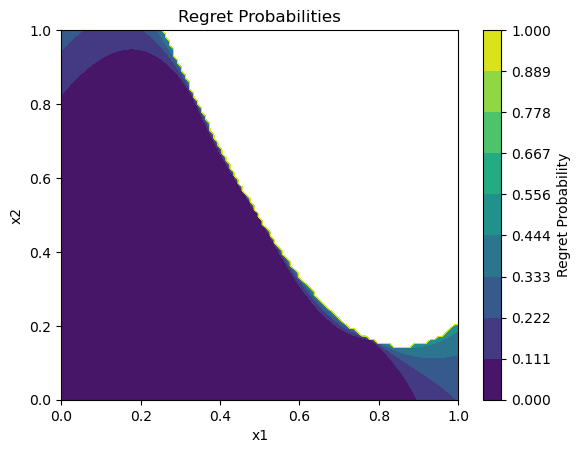

<Figure size 640x480 with 0 Axes>

In [6]:
#We need an area summation - figure out dx1/dx2
dx1 = 1./x1v.shape[0]
dx2 = 1./x2v.shape[1]

#Running totals of regret/windfall
running_regret = 0
running_windfall = 0

#We will also plot the regret/windall too
regret = np.empty_like(z2v)
windfall = np.empty_like(z2v)


for i in range(x1v.shape[0]):
    for j in range(x2v.shape[1]):
        model_input = np.array([[x1v[i,j], x2v[i,j]]])
        mn_val, std_val = gpr.predict(model_input, return_std=True)
        
        if mn_val < 0:   #Windfall chance
            num_std_dev_to_pos = -mn_val/std_val
            
            #Use standard normal distribution to convert to probability
            prob_feas = 1.0 - stats.norm.cdf(num_std_dev_to_pos)
            
            #Store this as the local windfall, and set the regret to a large value (for plotting only)
            windfall[i,j] = prob_feas
            regret[i,j] = 10
            
            #Add to our total
            running_windfall = prob_feas*dx1*dx2 + running_windfall
        
        else:  #Regret situation
            num_std_dev_to_negative = mn_val/std_val
            
            #Use standard normal distribution to convert to probability
            prob_neg = 1.0 - stats.norm.cdf(num_std_dev_to_negative)
            
            #Store this as the local regret, and set the windfall to a large value (for plotting only)
            windfall[i,j] = 10
            regret[i,j] = prob_neg
            
            #Add to our total
            running_regret = prob_neg*dx1*dx2 + running_regret

print('Stats for this run')
print('Total windfall ', running_windfall)
print('Total regret ', running_regret)

#Now make some plots
levels = np.linspace(0, 1, 10)  # Adjust the number of levels as needed
contour = plt.contourf(x1v, x2v, windfall, levels=levels, cmap='viridis')  # Choose a colormap
plt.colorbar(contour, label='Windfall Probability')  # Add colorbar with label

plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Windfall Probabilities')
plt.show()
plt.clf()

contour = plt.contourf(x1v, x2v, regret, levels=levels, cmap='viridis')  # Choose a colormap
plt.colorbar(contour, label='Regret Probability')  # Add colorbar with label

plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Regret Probabilities')
plt.show()
plt.clf()


